# Imports

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tabulate import tabulate
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from xgboost import XGBRegressor
from xgboost import plot_importance
from keras.callbacks import CSVLogger
from tabnanny import verbose
import coremltools as ct


print(tf.__version__)

2.9.2


# Define Plotting Functions

### Define Figure Resolution

In [49]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### Define Plots

In [8]:
def plot_loss(history, model_Name):
    plt.plot(history.history['val_loss'], label = 'Val Loss', color='b')
    plt.plot(history.history['loss'], label = 'Loss', color='g')
    plt.axhline(y=test_FSPL_value, color='r', linestyle='-', label = "FSPL")
    plt.ylim()
    # plt.figure(dpi=300)
    plt.xlabel('Epoch')
    plt.ylabel('Error [dB]')
    plt.title(f'{model_Name} Learning Curve')
    plt.legend()
    plt.grid(True)

def plot_loss_zoom(history, model_Name):
    plt.plot(history.history['val_loss'], label = 'Val Loss', color='b')
    plt.plot(history.history['loss'], label = 'Loss', color='g')
    plt.ylim([10,14])
    # plt.figure(dpi=300)
    plt.xlabel('Epoch')
    plt.ylabel('Error [dB]')
    plt.title(f'{model_Name} Learning Curve')
    plt.legend()
    plt.grid(True)

def plot_loss_medium_zoom(history, model_Name):
    plt.plot(history.history['val_loss'], label = 'Val Loss', color='b')
    plt.plot(history.history['loss'], label = 'Loss', color='g')
    plt.axhline(y=test_FSPL_value, color='r', linestyle='-', label = "FSPL")
    plt.ylim([0,20])
    plt.xlabel('Epoch')
    plt.ylabel('Error [dB]')
    plt.title(f'{model_Name} Learning Curve')
    plt.legend()
    plt.grid(True)

### Re-define plot resolution for bug fix

In [9]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Data Preperation

### Load Data into Training, Cross Validation, and Testing Data Frames

In [10]:
cities = ['boston', 'london', 'merthyr', 'nottingham', 'scarhill', 'southampton', 'stevenage']
 
wavelengths = ['0.91595','0.449425','1.8025','2.695','3.6025','5.85']

train_X = pd.DataFrame()
cv_X = pd.DataFrame()
test_X = pd.DataFrame()

for city in cities:
    for wavelength in wavelengths:
        if (city == 'merthyr'):
            df = pd.read_csv(f"../Data/trainingDataset/{city}{wavelength}.csv")
            cv_X = pd.concat([cv_X, df])
    
        elif (city == 'stevenage'):
            df = pd.read_csv(f"../Data/trainingDataset/{city}{wavelength}.csv")
            test_X = pd.concat([test_X, df])

        else:
            df = pd.read_csv(f"../Data/trainingDataset/{city}{wavelength}.csv")
            train_X = pd.concat([train_X, df])

### Determine the Percentage Split Between Datasets

In [11]:
percentTrain = train_X.shape[0] / 8_244_272.0
percentCV = cv_X.shape[0] / 8_244_272.0
percentTest = test_X.shape[0] / 8_244_272.0

print(f"Training Percentage: {percentTrain}")
print(f"Cross Validation Percentage: {percentCV}")
print(f"Test Percentage: {percentTest}")

Training Percentage: 0.7558046362371353
Cross Validation Percentage: 0.15829645116027224
Test Percentage: 0.08589891260259244


### Remove non-needed features

In [12]:
train_X.pop('Peak Avg. Height Diff')
train_X.pop('Peak Avg. Dist.')
train_X.pop('Max Peak')
train_X.pop('Peak Count')

cv_X.pop('Peak Avg. Height Diff')
cv_X.pop('Peak Avg. Dist.')
cv_X.pop('Max Peak')
cv_X.pop('Peak Count')

test_X.pop('Peak Avg. Height Diff')
test_X.pop('Peak Avg. Dist.')
test_X.pop('Max Peak')
test_X.pop('Peak Count')

0         11.0
1         11.0
2         11.0
3         11.0
4         11.0
          ... 
248519     0.0
248520     0.0
248521     0.0
248522     0.0
248523     0.0
Name: Peak Count, Length: 708174, dtype: float64

### Visualize the datasets' head using Tabulate

In [13]:
print(tabulate(train_X.head(5), 'keys'))

      Frequency    Power Loss    Distance    Height Difference
--  -----------  ------------  ----------  -------------------
 0      0.91595         82.67    0.193443                   14
 1      0.91595         84.78    0.224322                   14
 2      0.91595         86.63    0.224322                   14
 3      0.91595         86.68    0.255201                   14
 4      0.91595         88.48    0.255201                   14


### Determine how many NA values exist, remove them from all three datasets

In [14]:
print(train_X.isna().sum())
train_X = train_X.dropna()
cv_X = cv_X.dropna()
test_X = test_X.dropna()
print(train_X.isna().sum())

Frequency              0
Power Loss           631
Distance             631
Height Difference    631
dtype: int64
Frequency            0
Power Loss           0
Distance             0
Height Difference    0
dtype: int64


### Shuffle datasets for future plotting purposes

In [15]:
train_X = shuffle(train_X)
cv_X = shuffle(cv_X)
test_X = shuffle(test_X)

### Extract the targets from the datasets

In [16]:
train_Y = train_X.pop("Power Loss")
cv_Y = cv_X.pop("Power Loss")
test_Y = test_X.pop("Power Loss")

print(tabulate(train_X.head(5), 'keys'))

          Frequency    Distance    Height Difference
------  -----------  ----------  -------------------
 72243       3.6025     7.3185                   -62
 45273       5.85       3.18311                  -19
  4689       3.6025     9.5269                   -81
 12261       1.8025    19.0252                    13
125571       2.695      4.04876                  -12


### Set a universal early callback 

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

### Create Dictionary for Saving Results

In [18]:
test_results = {}

cv_results = {}

### Calculate Free Space Path Loss & Pull in ITM Values

In [19]:
train_FSPL = 20*np.log10(train_X['Distance']) + 20*np.log10(train_X['Frequency']) + 92.45
cv_FSPL = 20*np.log10(cv_X['Distance']) + 20*np.log10(cv_X['Frequency']) + 92.45
test_FSPL = 20*np.log10(train_X['Distance']) + 20*np.log10(test_X['Frequency']) + 92.45

train_FSPL_value = np.mean(np.abs(train_Y - train_FSPL))
cv_FSPL_value = np.mean(np.abs(cv_Y - cv_FSPL))
test_FSPL_value = np.mean(np.abs(test_Y - test_FSPL))


print(f"Training FSPL: {train_FSPL_value}")

Training FSPL: 33.21246259062219


### Create Normalization Layer

In [20]:
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_X))

print(normalizer.mean.numpy())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

[[  3.5693846  12.715287  -73.41759  ]]


# Random Forest

### Build Boosted Tree

In [21]:
default_tree_model = XGBRegressor()

default_tree_model.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### Evaluate Boosted Tree

In [22]:
y_pred = default_tree_model.predict(cv_X)
mse = np.mean(np.abs(cv_Y - y_pred))
print(mse)

10.237864612482946


### Create Feature Importance Plot

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

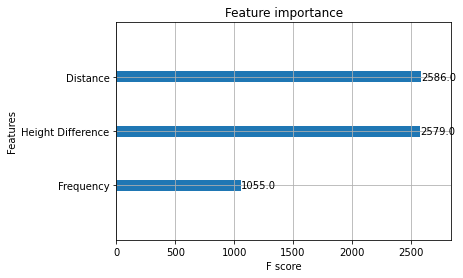

In [23]:
%matplotlib inline
plot_importance(default_tree_model)

# Multivaraible Linear Regression


### Build and Compile Model

In [24]:
linear_model= tf.keras.Sequential([
    normalizer,
    layers.Dense(units = 1)
])

## Compile model with optimizer and loss functions

linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = 'mean_absolute_error')

### Fit the model

In [25]:
history_linear = linear_model.fit(
    train_X,
    train_Y,
    epochs = 25,
    batch_size = 10000,
    verbose = 1,
    validation_data=(cv_X, cv_Y),
    callbacks=[callback]
)

Epoch 1/25
624/624 [==============================] - 4s 6ms/step - loss: 123.1979 - val_loss: 102.4308
Epoch 2/25
624/624 [==============================] - 4s 6ms/step - loss: 61.0601 - val_loss: 39.8153
Epoch 3/25
624/624 [==============================] - 3s 6ms/step - loss: 16.9692 - val_loss: 11.9645
Epoch 4/25
624/624 [==============================] - 3s 6ms/step - loss: 12.5608 - val_loss: 11.5166
Epoch 5/25
624/624 [==============================] - 3s 6ms/step - loss: 12.5571 - val_loss: 11.5335
Epoch 6/25
624/624 [==============================] - 3s 6ms/step - loss: 12.5570 - val_loss: 11.3124
Epoch 7/25
624/624 [==============================] - 3s 6ms/step - loss: 12.5571 - val_loss: 11.3917
Epoch 8/25
624/624 [==============================] - 3s 6ms/step - loss: 12.5572 - val_loss: 11.4307
Epoch 9/25
624/624 [==============================] - 3s 6ms/step - loss: 12.5571 - val_loss: 11.3503


### Plot Learning Curve

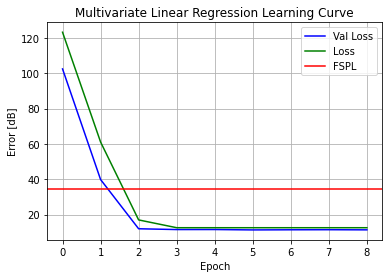

In [26]:
plot_loss(history_linear, "Multivariate Linear Regression")

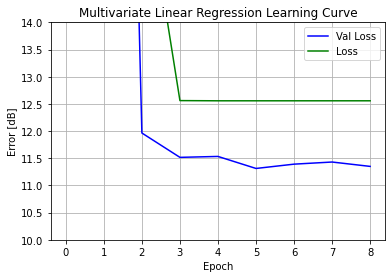

In [27]:
plot_loss_zoom(history_linear, "Multivariate Linear Regression")

### Collect results for later

In [28]:
test_results['Multivariate Regression'] = linear_model.evaluate(
    test_X, 
    test_Y, 
    verbose = 1
)

cv_results['Multivariate Regression'] = linear_model.evaluate(
    cv_X, 
    cv_Y, 
    verbose = 1
)

40783/40783 [==============================] - 127s 3ms/step - loss: 11.3503


# Base DNN

### Define Build and Compile Function

In [29]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss = 'mean_absolute_error',
        optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    )

    return model

### Build and compile

In [30]:
base_dnn_model = build_and_compile_model(normalizer)

### Train Model

In [31]:
%%time

history_base_dnn = base_dnn_model.fit(
    train_X,
    train_Y,
    epochs = 50,
    batch_size = 10000,
    validation_data = (cv_X, cv_Y),
    verbose = 1,
    callbacks=[callback]
)

Epoch 1/50
624/624 [==============================] - 5s 8ms/step - loss: 50.2858 - val_loss: 12.2199
Epoch 2/50
624/624 [==============================] - 5s 8ms/step - loss: 10.7265 - val_loss: 9.8838
Epoch 3/50
624/624 [==============================] - 5s 8ms/step - loss: 9.9654 - val_loss: 9.8103
Epoch 4/50
624/624 [==============================] - 5s 8ms/step - loss: 9.7737 - val_loss: 9.3324
Epoch 5/50
624/624 [==============================] - 5s 8ms/step - loss: 9.6530 - val_loss: 9.3527
Epoch 6/50
624/624 [==============================] - 5s 8ms/step - loss: 9.4850 - val_loss: 9.0087
Epoch 7/50
624/624 [==============================] - 5s 8ms/step - loss: 9.1715 - val_loss: 9.2581
Epoch 8/50
624/624 [==============================] - 5s 8ms/step - loss: 8.8414 - val_loss: 9.1031
Epoch 9/50
624/624 [==============================] - 5s 8ms/step - loss: 8.6388 - val_loss: 9.4266
CPU times: user 35.4 s, sys: 15.5 s, total: 50.9 s
Wall time: 44.4 s


### Visualize Training

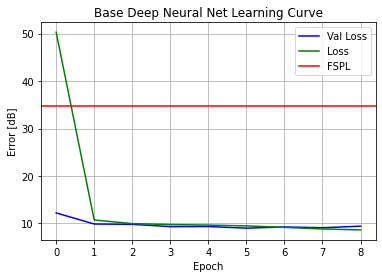

In [32]:
plot_loss(history_base_dnn, "Base Deep Neural Net")

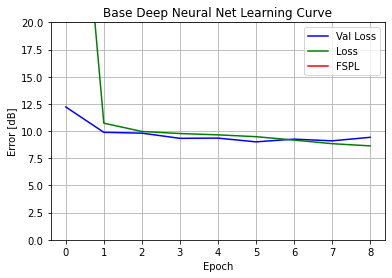

In [33]:
plot_loss_medium_zoom(history_base_dnn, "Base Deep Neural Net")

### Collect Results

In [34]:
test_results['Base Deep Neural Net'] = base_dnn_model.evaluate(
    test_X,
    test_Y,
    verbose = 1
)

cv_results['Base Deep Neural Net'] = base_dnn_model.evaluate(
    cv_X,
    cv_Y,
    verbose = 1
)

40783/40783 [==============================] - 142s 3ms/step - loss: 9.4266


# Tuned DNN

### Build and compile

In [35]:
tuned_dnn_model = build_and_compile_model(normalizer)

### Train Model

In [36]:
%%time

history_tuned_dnn = tuned_dnn_model.fit(
    train_X,
    train_Y,
    epochs = 50,
    batch_size = 4,
    validation_data = (cv_X, cv_Y),
    verbose = 1,
    callbacks=[callback]
)

Epoch 1/50
1557607/1557607 [==============================] - 8150s 5ms/step - loss: 8.4990 - val_loss: 8.6487
Epoch 2/50
1557607/1557607 [==============================] - 8288s 5ms/step - loss: 7.9412 - val_loss: 8.6550
Epoch 3/50
1557607/1557607 [==============================] - 8209s 5ms/step - loss: 7.8302 - val_loss: 8.7692
Epoch 4/50
1557607/1557607 [==============================] - 8233s 5ms/step - loss: 7.7737 - val_loss: 8.9560
CPU times: user 7h 31min 53s, sys: 3h 9min 29s, total: 10h 41min 23s
Wall time: 9h 8min


### Visualize Training

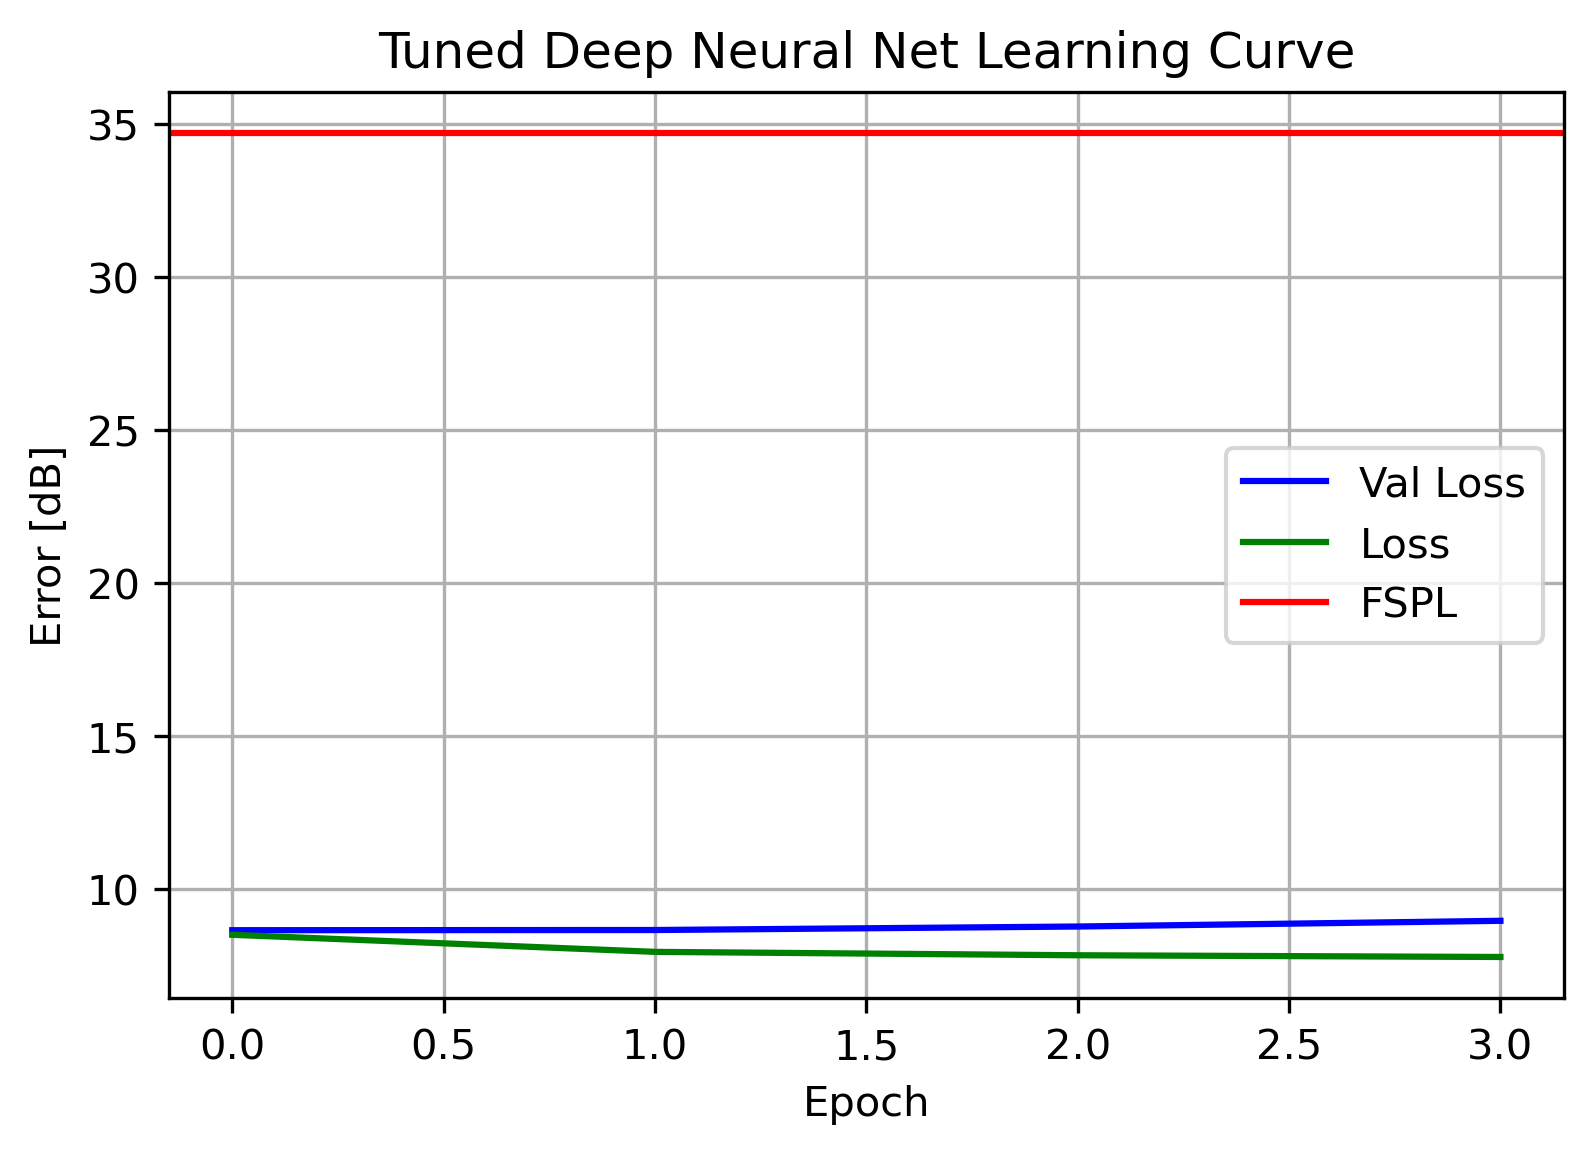

In [50]:
plot_loss(history_tuned_dnn, "Tuned Deep Neural Net")

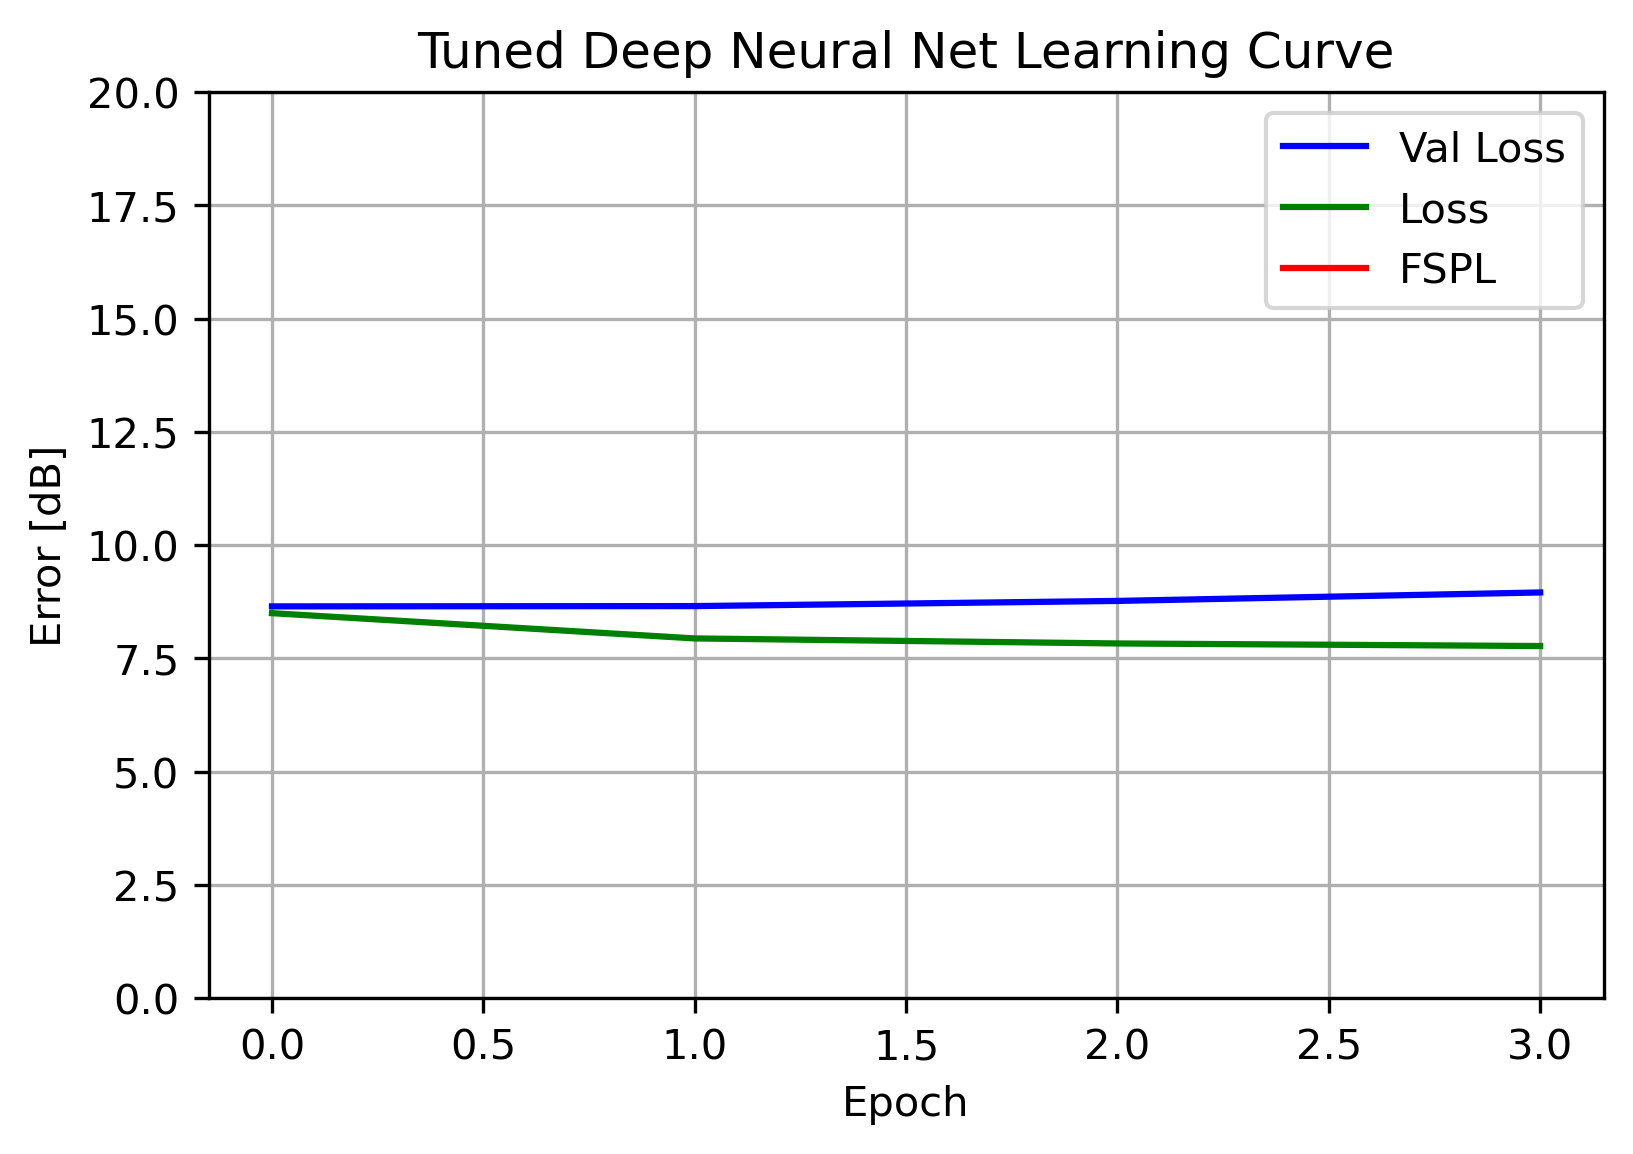

In [51]:
plot_loss_medium_zoom(history_tuned_dnn, "Tuned Deep Neural Net")

### Collect Results

In [52]:
test_results['Tuned Deep Neural Net'] = tuned_dnn_model.evaluate(
    test_X,
    test_Y,
    verbose = 1
)

cv_results['Tuned Deep Neural Net'] = tuned_dnn_model.evaluate(
    cv_X,
    cv_Y,
    verbose = 1
)

40783/40783 [==============================] - 147s 4ms/step - loss: 8.9561


# Results

In [53]:
pd.DataFrame(cv_results, index=['Mean absolute error [dB]']).T

,Mean absolute error [dB]
Multivariate Regression,11.350289
Base Deep Neural Net,9.426564
Tuned Deep Neural Net,8.956051
Regularized Deep Neural Net,10.669473


In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [dB]']).T

,Mean absolute error [dB]
Multivariate Regression,13.302615
Base Deep Neural Net,10.572522
Tuned Deep Neural Net,11.249246
Regularized Deep Neural Net,11.249268


# Convert to CoreML

In [48]:
mlmodel = ct.convert(tuned_dnn_model, convert_to="mlprogram")

NameError: name 'dnn_model' is not defined

In [ ]:
# Save model as a Core ML model package
mlmodel.save("Sig-Map.mlpackage")